# Face Verification

The basic idea behind face recognition can be illustrated using the example below where I employ the use of the following: 
- Transfer learning: We use the VGG 16 model and the VGG Face model using a compressed layer after autoencoding. Freeze layers along with modifying the neural network architecture
- Use distance functions (euclidean and cosine) to determine matches

[Concept Reference](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/)

In [23]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential, load_model, model_from_json, Model
from keras.layers import Activation , Dropout
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


## Transfer Learning 

Lets load in the VGG16 pretrained model. Here we do the following: 
- (i) Load in the model
- (ii) Modify architecture: remove last 2 dense layers. Add softmax activation on the resultant last layer
- (iii) Freeze VGG_16 face model weights

### (i) Loading in the model

In [3]:
"""
KERAS.APPLICATIONS
- Keras has a repo of pretrained models that you can simply pull from to further your training or use it however you want. 

Note: we will use imagenet weights on the model we import
"""
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet')

In [4]:
# Lets check out the pre-trained model we're going to tune!
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### (ii) Modify model architecture
- remove last 3 dense layers. 
- Add softmax activation
- freezing our weights

In [30]:
# Transform here
face_model = Sequential()

#creating our own modelfrom the VGG 16
for layer in vgg16_model.layers[:-2]:
    face_model.add(layer)

In [31]:
#Adding softmax activation
face_model.add(Activation('softmax'))

In [33]:
#lets view our new model
face_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

### (iii) Freezing all the weights!

The VGG16 model has already been pretrained on a large dataset and therefore we simply "transfer" the use of the model for our purpose as the convolutional neural network already has the capability of succeafully identifying image features

In [34]:
#freezing all weights
for layer in face_model.layers:
    layer.trainable = False

## Using the model

We will do the following here: 
- (i) Read in our images and resize
- (ii) represent the flattened images 
- (iii) then performing face verification

### (i) Reading & resizing

In [32]:
#read in images and resize
def resize(my_image):
    img = Image.open(my_image)
    img.load()
    img = img.resize((224, 224), Image.ANTIALIAS)    
    data = np.asarray( img, dtype="int32" )
    return data.reshape(1,224,224,3)             #model expects 4 dims
img1 = resize('C:/Users/Darshil/Desktop/and_darsh.jpg')
img2 = resize('C:/Users/Darshil/Desktop/darsh.jpg')

### (ii) Lets represent an image as a flattened layer

In [8]:
# Here we have simply passed the 2 images through the custom VGG16 convolutional neural network we've modified 
#model.predict(img1)
face_model.predict(img2)

NameError: name 'face_model' is not defined

In [52]:
#define thresholds 
#epsilon = 0.40 #cosine similarity
epsilon = 1 #euclidean distance

def euclidean_distance(image1,image2, pickmodel,upper_thresh,mid_thresh):
    # Lastly we can perform the face verification
    p_img1 = pickmodel.predict(image1)
    p_img2 = pickmodel.predict(image2)

    #distance function
    diff = p_img1 - p_img2
    a = np.sum(np.multiply(diff,diff))
    euc_dist = np.sqrt(a) 
        
    if euc_dist < upper_thresh and euc_dist > mid_thresh:
        printy ='Possible face match!'
    elif euc_dist < mid_thresh:
        printy = 'Great chance its a face match!'
    else:
        printy = 'Def not a face match'
    
    #print (euc_dist, '\n')
    return (printy,', score: ',euc_dist)

euclidean_distance(resize('leo1.jpg'),resize('darsh1.jpg'),face_model)
euclidean_distance(resize('leo1.jpg'),resize('leo2.jpg'),face_model)
euclidean_distance(resize('leo2.jpg'),resize('leo3.jpg'),face_model)

NameError: name 'face_model' is not defined

In [9]:
distance(resize('C:/Users/Darshil/Desktop/darsh1.jpg'),resize('C:/Users/Darshil/Desktop/randface1.jpg'))

NameError: name 'distance' is not defined

# Using the VGG Face model

Although the architecture is kind of similar, the VGG face model was trained on an entirely different dataset and hence has different weights. 

We will do the following: 
- (i) create a VGG FACE MODEL 
- (ii) Load up the weights
- (iii) Select an output layer as an image representation 
- (iv) Create a database (a dictionary for now) then conduct face verification on each image within the data structure

### (i)

In [2]:
# Model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

model.summary()

### (ii) Loading VGG Face Weights
These weights are from the VGG face model (loaded above) which was trained on by researchers on a special dataset comprising faces

In [5]:
#here we load the weights
model.load_weights('vgg_face_weights.h5')

### (iii) Selecting output layer

##### Important: We use the flattened convolutional layer before the output layer to represent our image
- Although we learned that we take the middle layer (compressed) one to represent our data. Here we do not but instead deem the last conv layer (conv2d_32 AFTER activation) to be a better representation

In [6]:
#here we modify the existing model such that we only pass the input data through the number of decided layers
vgg_face_descriptor = Model(inputs=model.layers[0].input
, outputs=model.layers[-2].output)

In [66]:
#prediction on a random image
vgg_face_descriptor.predict(resize('randface1.jpg'))

array([[ 3.8608427, -1.2944626,  1.9846333, ..., -5.0190635,  3.6953394,
         1.9678347]], dtype=float32)

In [10]:
# Here we have simply passed the 2 images through the custom VGG16 FACE NETWORK uptil the conv2d_32 layer
print ("Shape of convolutional layer we're using to represent our image data : " , vgg_face_descriptor.predict(img2).shape)

Shape of convolutional layer we're using to represent our image data :  (1, 2622)


In [47]:
#Trying out the euclidean distance
"""
EUCLIDEAN DISTANCES
- Note that we picked our threshold (120) using the helper articles. But in practice the process takes more iterations
"""
#now we implement and find euclidean distances!  
euclidean_distance(resize('leo1.jpg'),resize('darsh1.jpg'),vgg_face_descriptor,120,150)
euclidean_distance(resize('leo1.jpg'),resize('leo2.jpg'),vgg_face_descriptor,120,150)

('Good chance its a match!', ', score: ', 79.49031)

### (iv) Create a database , conduct face verification 

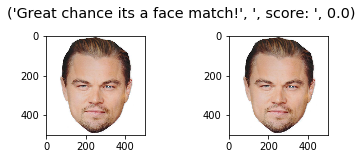

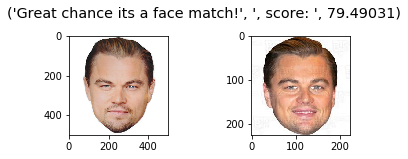

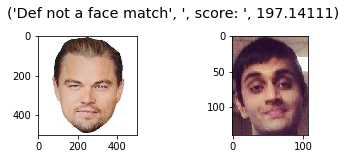

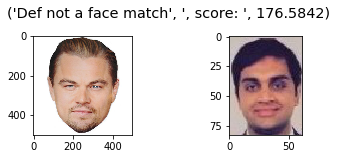

In [53]:
database = {
    'Leo': ['leo1.jpg', 'leo2.jpg'],
    'Darsh': ['darsh.jpg', 'darsh1.jpg']    
}

sourcey = 'leo1.jpg'
for x in database:
    for y in database[x]:
        
        
        fig = plt.figure()
        st = fig.suptitle(euclidean_distance(resize(sourcey),resize(y),vgg_face_descriptor,120,150), fontsize="x-large")
        ax1 = fig.add_subplot(2,2,1)
        img1=mpimg.imread(sourcey)
        ax1.imshow(img1)
                
        ax2 = fig.add_subplot(2,2,2)
        img2=mpimg.imread(y)
        ax2.imshow(img1)
        ax2.imshow(img2)

        

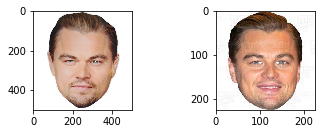

In [40]:
"""
#SUBPLOT HELPER CODE

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
img1=mpimg.imread('leo1.jpg')
ax1.imshow(img1)

ax2 = fig.add_subplot(2,2,2)
img2=mpimg.imread('leo2.jpg')
ax2.imshow(img1)
ax2.imshow(img2)
"""

# OpenCV Realtime Face Detection

In [83]:
"""import cv2
from skimage.transform import resize 
#importing face cascades
face_cascade = cv2.CascadeClassifier('C:/Users/Darshil/Desktop/Dreams/haarcascade_frontalface_default.xml')

#font
font = cv2.FONT_HERSHEY_SIMPLEX

"""

In [2]:
""# Now we turn on the camera
cap = cv2.VideoCapture(0)

while True:
    ret, img = cap.read(20) 
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        #converting into grayscale
    faces = face_cascade.detectMultiScale(img,1.3,5)
      
    """FACES"""
    #N1. important to note that smile_cascade and eye_cascades need to be used within the face identified!
    for (x,y,w,h) in faces:                             #faces gives us x,y,w,h of the faces so now we use those
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)       #draw a rectangle using the x,y,w,h coordinates
        roi_color = img[y:y+h,x:x+w]                      #N1. take a colored image of the face to use with other cascades

        detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
        detected_face = cv2.resize(detected_face, (224, 224)) #resize to 224x224

        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255        
        
        a = str(euclidean_distance(resizee(img_pixels),resizee('leo3.jpg'),vgg_face_descriptor,120,150))
        
        cv2.putText(img,a, (x,y),font,0.7,(200,255,255),1,cv2.LINE_AA)  #IMAGE,text,position start,font,size,color,thickness,-
        
    cv2.imshow('img',img)    #show full image
    
    if cv2.waitKey(5)== ord('q'):        #break when pressing "q"
        break
        
cv2.destroyAllWindows()
cap.release()    
"""

NameError: name 'cv2' is not defined